In [ ]:
! rm -r transformers
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip install ./transformers

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 261327, done.
remote: Counting objects: 100% (624/624), done.
remote: Compressing objects: 100% (275/275), done.
remote: Total 261327 (delta 503), reused 349 (delta 349), pack-reused 260703 (from 3)
Receiving objects: 100% (261327/261327), 271.84 MiB | 11.98 MiB/s, done.
Resolving deltas: 100% (192895/192895), done.
Updating files: 100% (5076/5076), done.
Processing ./transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.50.0.dev0-py3-none-any.whl size=10877629 sha256=407e2c4bfc6a0a056c1834fbe5cf1343ecb40d4a2befc430afb02126692bf591
  Stored in directory: /tmp/pip-ephem-wheel-cache-04v9svqq/wheels/9f/62/72/77fdff469e8308ad837268261590df9cabff9926cc4ab177c0
Successfully built transformers
  Attempting uninstall: transfor

In [ ]:
# ubuntu
!sudo apt install -y tesseract-ocr
# python
!pip install pytesseract transformers datasets seqeval tensorboard
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,632 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
processor_id="microsoft/layoutlmv2-base-uncased"
dataset_id ="nielsr/funsd"

In [ ]:
from datasets import load_dataset


dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")
# Train dataset size: 149
# Test dataset size: 50

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


funsd.py:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

The repository for nielsr/funsd contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nielsr/funsd.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Train dataset size: 149
Test dataset size: 50


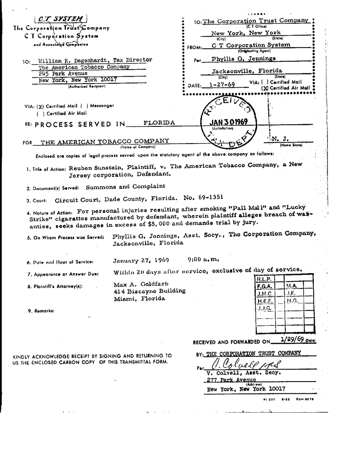

In [ ]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(dataset['train'][34]['image_path'])
image = image.convert("RGB")
image.resize((350,450))

In [ ]:
labels = dataset['train'].features['ner_tags'].feature.names
print(f"Available labels: {labels}")

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
#     Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [ ]:
from transformers import LayoutLMv2Processor

# use LayoutLMv2 processor without ocr since the dataset already includes the ocr text
processor = LayoutLMv2Processor.from_pretrained(processor_id, apply_ocr=False)

preprocessor_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

In [ ]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D


# we need to define custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(Value(dtype="int64")),
        "token_type_ids": Sequence(Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

# preprocess function to perpare into the correct format for the model
def process(sample, processor=None):
    encoding = processor(
        Image.open(sample["image_path"]).convert("RGB"),
        sample["words"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    del encoding["image"]
    return encoding


# process the dataset and format it to pytorch
proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")

print(proc_dataset["train"].features.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox','lables'])


Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])


In [ ]:
from transformers import LayoutLMForTokenClassification

# huggingface hub model id
model_id = "microsoft/layoutlm-base-uncased"

# load model with correct number of labels and mapping
model = LayoutLMForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)

config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
import evaluate
import numpy as np

# load seqeval metric
metric = evaluate.load("seqeval")

# labels of the model
ner_labels = list(model.config.id2label.values())


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])


In [ ]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments

# hugging face parameter
repository_id = "layoutlm-funsd"

# Define training args
training_args = TrainingArguments(
    output_dir=repository_id,
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    fp16=True,
    learning_rate=3e-5,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,Answer,Header,Question,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,1.744900,1.553725,"{'precision': 0.0295159386068477, 'recall': 0.030902348578491966, 'f1': 0.030193236714975848, 'number': 809}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}","{'precision': 0.39888268156424583, 'recall': 0.3352112676056338, 'f1': 0.3642857142857142, 'number': 1065}",0.219288,0.191671,0.204552,0.405440
2,1.430400,1.235493,"{'precision': 0.1640953716690042, 'recall': 0.1446229913473424, 'f1': 0.1537450722733246, 'number': 809}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}","{'precision': 0.4215900802334063, 'recall': 0.5427230046948357, 'f1': 0.4745484400656814, 'number': 1065}",0.333493,0.348721,0.340937,0.590124
3,1.107700,0.948311,"{'precision': 0.4903553299492386, 'recall': 0.5970333745364648, 'f1': 0.5384615384615384, 'number': 809}","{'precision': 0.09523809523809523, 'recall': 0.01680672268907563, 'f1': 0.02857142857142857, 'number': 119}","{'precision': 0.5883256528417818, 'recall': 0.7192488262910798, 'f1': 0.6472327841149134, 'number': 1065}",0.542028,0.627697,0.581725,0.718889
4,0.845500,0.783494,"{'precision': 0.6149897330595483, 'recall': 0.7404202719406675, 'f1': 0.6719012899607404, 'number': 809}","{'precision': 0.0392156862745098, 'recall': 0.01680672268907563, 'f1': 0.023529411764705882, 'number': 119}","{'precision': 0.6456628477905073, 'recall': 0.7408450704225352, 'f1': 0.689986882378662, 'number': 1065}",0.618603,0.697441,0.655660,0.756713
5,0.672000,0.715994,"{'precision': 0.6618464961067854, 'recall': 0.7354758961681088, 'f1': 0.6967213114754098, 'number': 809}","{'precision': 0.24050632911392406, 'recall': 0.15966386554621848, 'f1': 0.1919191919191919, 'number': 119}","{'precision': 0.6773934030571199, 'recall': 0.7906103286384977, 'f1': 0.7296360485268631, 'number': 1065}",0.655561,0.730557,0.691030,0.784147
6,0.562600,0.680560,"{'precision': 0.673773987206823, 'recall': 0.7812113720642769, 'f1': 0.7235260446479679, 'number': 809}","{'precision': 0.2619047619047619, 'recall': 0.18487394957983194, 'f1': 0.21674876847290642, 'number': 119}","{'precision': 0.7359792924935289, 'recall': 0.8009389671361502, 'f1': 0.7670863309352518, 'number': 1065}",0.690967,0.756147,0.722089,0.788816
7,0.484900,0.656604,"{'precision': 0.6920600858369099, 'recall': 0.7972805933250927, 'f1': 0.7409534750143596, 'number': 809}","{'precision': 0.35106382978723405, 'recall': 0.2773109243697479, 'f1': 0.3098591549295775, 'number': 119}","{'precision': 0.747870528109029, 'recall': 0.8244131455399061, 'f1': 0.7842786958463601, 'number': 1065}",0.707273,0.780733,0.742189,0.802008
8,0.434300,0.663976,"{'precision': 0.7161862527716186, 'recall': 0.7985166872682324, 'f1': 0.7551139684395091, 'number': 809}","{'precision': 0.28440366972477066, 'recall': 0.2605042016806723, 'f1': 0.2719298245614035, 'number': 119}","{'precision': 0.75809199318569, 'recall': 0.8356807511737089, 'f1': 0.7949977668602054, 'number': 1065}",0.717162,0.786252,0.750120,0.801307
9,0.379700,0.673468,"{'precision': 0.6981339187705817, 'recall': 0.7861557478368356, 'f1': 0.7395348837209302, 'number': 809}","{'precision': 0.3162393162393162, 'recall': 0.31092436974789917, 'f1': 0.3135593220338983, 'number': 119}","{'precision': 0.7615720524017467, 'recall': 0.8187793427230047, 'f1': 0.7891402714932126, 'number': 1065}",0.710999,0.775213,0.741719,0.799089
10,0.375300,0.670724,"{'precision': 0.7182628062360802, 'recall': 0.7972805933250927, 'f1': 0.7557117750439368, 'number': 809}","{'precision': 0.2892561983471074, 'recall': 0.29411764705882354, 'f1': 0.2916666666666667, 'number': 119}","{'precision': 0.7731239092495636, 'recall': 0.831924882629108, 'f1': 0.8014473089099955, 'number': 1065}",0.723326,0.785750,0.753247,0.807962


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0295159386068477, 'recall': 0.030902348578491966, 'f1': 0.030193236714975848, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.39888268156424583, 'recall': 0.3352112676056338, 'f1': 0.3642857142857142, 'number': 

In [ ]:
# change apply_ocr to True to use the ocr text for inference
processor.feature_extractor.apply_ocr = True

# Save processor and create model card
processor.save_pretrained(repository_id)
trainer.create_model_card()
trainer.push_to_hub()

/usr/local/lib/python3.11/dist-packages/transformers/models/layoutlmv2/processing_layoutlmv2.py:197: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


events.out.tfevents.1741300640.0107f970b0bb.206.0:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/anipani/layoutlm-funsd/commit/9d01c2d323ed0de6614a49ad29e6a2e75c83360d', commit_message='End of training', commit_description='', oid='9d01c2d323ed0de6614a49ad29e6a2e75c83360d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/anipani/layoutlm-funsd', endpoint='https://huggingface.co', repo_type='model', repo_id='anipani/layoutlm-funsd'), pr_revision=None, pr_num=None)

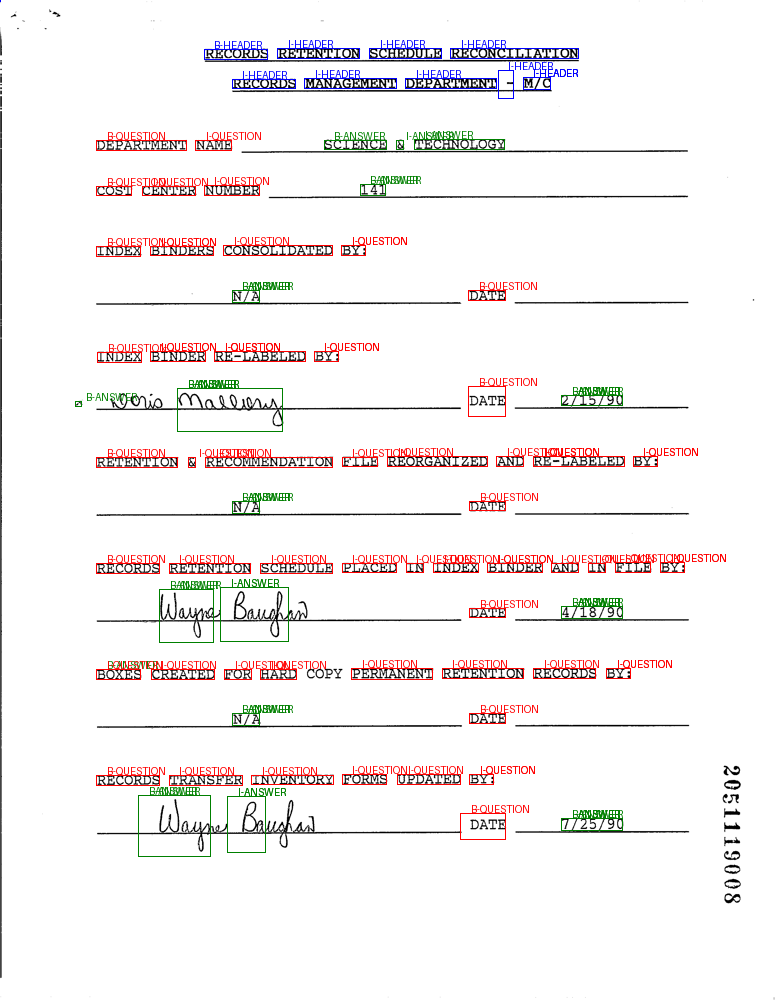

In [ ]:
from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
model = LayoutLMForTokenClassification.from_pretrained("philschmid/layoutlm-funsd")
processor = LayoutLMv2Processor.from_pretrained("philschmid/layoutlm-funsd")


# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}
# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(path, model=model, processor=processor, output_image=True):
    # create model input
    image = Image.open(path).convert("RGB")
    encoding = processor(image, return_tensors="pt")
    del encoding["image"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels


run_inference(dataset["test"][34]["image_path"])

In [ ]:
!pip install pdf2image

In [ ]:
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 1s (179 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 124994 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
def extract_tokens_labels_boxes(pdf_path, model, processor):
    """
    Returns:
      tokens: subword tokens
      labels: predicted label for each token
      bboxes: bounding boxes for each token
    """
    from pdf2image import convert_from_path
    from PIL import Image

    # Convert PDF to images
    pages = convert_from_path(pdf_path, dpi=300)
    image = pages[0].convert("RGB")

    # Truncate/pad so we never exceed 512 tokens
    encoding = processor(
        image,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding="max_length"
    )
    input_ids = encoding["input_ids"].squeeze()  # shape: [512]
    bboxes = encoding["bbox"].squeeze().tolist() # shape: [512, 4]

    # The model doesn't need the raw image tensor
    del encoding["image"]

    # Run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()  # shape: [512]

    # Convert predicted IDs to label strings
    labels = [model.config.id2label[p] for p in predictions]

    # Convert token IDs back to actual subword tokens
    tokens = processor.tokenizer.convert_ids_to_tokens(input_ids)

    return tokens, labels, bboxes


In [ ]:
def group_subwords(tokens, labels, bboxes):
    """
    Groups subword tokens into word-level tokens based on bounding boxes.
    Returns a list of (word, label, bbox).
    """
    grouped = []
    current_tokens = []
    current_labels = []
    current_bbox = []

    prev_bbox = None

    for token, label, bbox in zip(tokens, labels, bboxes):
        # Skip special tokens
        if token in ["[CLS]", "[SEP]", "[PAD]"]:
            continue

        # Start a new group if the bbox changed
        if not current_tokens or bbox != prev_bbox:
            # If there's a current group, push it
            if current_tokens:
                merged_word = processor.tokenizer.convert_tokens_to_string(current_tokens)
                # For simplicity, we take the first label/bbox in the group
                grouped.append((merged_word, current_labels[0], current_bbox[0]))

            current_tokens = [token]
            current_labels = [label]
            current_bbox = [bbox]
        else:
            # Continue the existing group
            current_tokens.append(token)
            current_labels.append(label)
            current_bbox.append(bbox)

        prev_bbox = bbox

    # Add the last group if any
    if current_tokens:
        merged_word = processor.tokenizer.convert_tokens_to_string(current_tokens)
        grouped.append((merged_word, current_labels[0], current_bbox[0]))

    return grouped


In [ ]:
def extract_questions_answers(word_level_data):
    """
    Given a list of (word, label, bbox), return lists of question words and answer words.
    """
    questions = []
    answers = []

    for word, label, bbox in word_level_data:
        # e.g. B-QUESTION or I-QUESTION
        if "QUESTION" in label:
            questions.append(word)
        # e.g. B-ANSWER or I-ANSWER
        elif "ANSWER" in label:
            answers.append(word)

    return questions, answers



In [ ]:
# 1. Extract tokens, labels, bounding boxes
tokens, labels, bboxes = extract_tokens_labels_boxes(
    "/content/11799_grdnshp_inventory-2.pdf",
    model=model,
    processor=processor
)

# 2. Group subwords into word-level data
word_level_data = group_subwords(tokens, labels, bboxes)

# 3. Extract question words and answer words
questions, answers = extract_questions_answers(word_level_data)

print("Extracted Questions:", questions)
print("Extracted Answers:", answers)



Extracted Questions: ['notice', 'interested', 'parties :', 'in', 'the', 'matter', 'of', 'the', 'estate', 'of,', 'county', 'of', 'no.', 'guardian ( s )', 'of', 'the', 'estate', 'hereby', 'date', 'signature', 'print', 'name', 'date', 'signature', 'print', 'name', 'schedule', 'a', '-', 'real', 'property', 'schedule', 'b', '-', 'stocks,', 'bonds,', 'mutual', 'funds,', 'securities', 'and', 'investment', 'accounts', 'schedule', 'c', '-', 'cash,', 'bank', 'accounts,', 'notes', 'due', 'schedule', 'd', '-', 'pensions,', 'retirement', 'accounts,', 'annuities,', 'profit', 'sharing', 'plans', 'schedule', 'e', '-', 'miscellaneous', 'personal', 'property', 'gross', 'value', 'schedule', 'f', '-', 'encumbrances', 'total', 'net', 'estate', 'schedule', 'g', '-', 'monthly', 'income']
Extracted Answers: ['chancery', 'panicker', '6 / 3 / 2025', 'anish', '$', '$', '2000. 00', '$', '300. 00', '$', '$', '909', '$', '$', '$']


In [ ]:
from pdf2image import convert_from_path
from PIL import Image
import torch

def extract_tokens_labels_boxes(pdf_path, model, processor):
    from pdf2image import convert_from_path
    from PIL import Image
    import torch

    # Convert PDF to images
    pages = convert_from_path(pdf_path, dpi=300)
    image = pages[0].convert("RGB")

    # Truncate/pad so we never exceed 512 tokens
    encoding = processor(
        image,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding="max_length"
    )

    input_ids = encoding["input_ids"].squeeze()
    # Convert bounding boxes from list -> tuple
    bboxes = encoding["bbox"].squeeze().tolist()
    bboxes = [tuple(box) for box in bboxes]  # <-- ADD THIS LINE

    del encoding["image"]

    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()

    labels = [model.config.id2label[p] for p in predictions]
    tokens = processor.tokenizer.convert_ids_to_tokens(input_ids)

    return tokens, labels, bboxes


In [ ]:
def group_subwords(tokens, labels, bboxes, processor):
    grouped = []
    current_tokens = []
    current_labels = []
    current_bbox = None

    for token, label, bbox in zip(tokens, labels, bboxes):
        # Skip special tokens
        if token in ["[CLS]", "[SEP]", "[PAD]"]:
            continue

        # If this token starts a new entity (B-) or the bbox changes, finish the current group
        if (label.startswith("B-") or (current_bbox is not None and bbox != current_bbox)):
            if current_tokens:
                merged_word = processor.tokenizer.convert_tokens_to_string(current_tokens)
                grouped.append((merged_word, current_labels[0], current_bbox))
            current_tokens = [token]
            current_labels = [label]
            current_bbox = bbox
        else:
            # Otherwise, continue the group (this handles I- tokens)
            current_tokens.append(token)
            current_labels.append(label)
            # We keep current_bbox unchanged

    # Append any remaining group
    if current_tokens:
        merged_word = processor.tokenizer.convert_tokens_to_string(current_tokens)
        grouped.append((merged_word, current_labels[0], current_bbox))
    return grouped



In [ ]:
def extract_phrases(word_level_data):
    question_phrases = []
    answer_phrases = []

    current_question = []
    current_answer = []

    for word, label, bbox in word_level_data:
        # Group QUESTION phrases
        if label.startswith("B-QUESTION"):
            if current_question:
                question_phrases.append(" ".join(current_question))
                current_question = []
            current_question.append(word)
        elif label.startswith("I-QUESTION"):
            current_question.append(word)
        else:
            if current_question:
                question_phrases.append(" ".join(current_question))
                current_question = []

        # Group ANSWER phrases
        if label.startswith("B-ANSWER"):
            if current_answer:
                answer_phrases.append(" ".join(current_answer))
                current_answer = []
            current_answer.append(word)
        elif label.startswith("I-ANSWER"):
            current_answer.append(word)
        else:
            if current_answer:
                answer_phrases.append(" ".join(current_answer))
                current_answer = []

    if current_question:
        question_phrases.append(" ".join(current_question))
    if current_answer:
        answer_phrases.append(" ".join(current_answer))

    return question_phrases, answer_phrases


In [ ]:
def pair_phrases(question_phrases, answer_phrases):
    # Pair them by index (you can refine this based on layout if needed)
    pairs = list(zip(question_phrases, answer_phrases))
    return pairs
